<H1><center>Final project: predict future sales</center></H1>
<H2><center>Coursera  How to Win a Data Science Competition</center></H2>

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.



### Data fields description:
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* date - date in format dd/mm/yyyy
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

### Requirements
* datetime
* numpy
* pandas
* seaborn
* matplotlib
* catboost
* sklearn

In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Loading data

In [2]:
test = pd.read_csv('../input/test.csv.gz', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})
item_categories = pd.read_csv('../input/item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv('../input/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})
shops = pd.read_csv('../input/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales = pd.read_csv('../input/sales_train.csv.gz', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

### Join data sets

In [3]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

### Let's take a look at the raw data

In [4]:
print('Train rows: ', train.shape[0])
print('Train columns: ', train.shape[1])

Train rows:  2935849
Train columns:  10


In [5]:
train.head().T

,0,1,2,3,4
date,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-05-01 00:00:00,2013-06-01 00:00:00,2013-01-15 00:00:00
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999.00,899.00,899.00,1709.05,1099.00
item_cnt_day,1,1,-1,1,1
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)
item_category_id,37,58,58,58,56
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
item_category_name,Кино - Blu-Ray,Музыка - Винил,Музыка - Винил,Музыка - Винил,Музыка - CD фирменного производства


In [6]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.62,1.24,40.00
std,9.42,16.23,6324.30,1726.44,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


### Time period

In [7]:
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2015-12-10


### Data preprocessing
We are asked to predict total sales for every product and store in the next month, and our data is given by day, so let's remove unwanted columns and aggregate the data by month.

In [8]:
# Select only usefeul features (here I won't be using the text features).
train_monthly = train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]
# # Group by month in this case "date_block_num" and aggregate features.
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_price':['sum'], 'item_cnt_day':['sum','count']})
# # Rename features.
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt', 'transactions']

### New dataset

In [9]:
train_monthly.head(10).T

,0,1,2,3,4,5,6,7,8,9
date_block_num,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
shop_id,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
item_category_id,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00
item_id,5572.00,5573.00,5575.00,5576.00,5609.00,5612.00,5623.00,5627.00,5629.00,5630.00
item_price,7932.00,560.00,2418.00,11155.00,2381.00,3623.00,294.00,4120.00,15400.00,2060.00
item_cnt,10.00,1.00,4.00,5.00,1.00,1.00,1.00,2.00,9.00,1.00
transactions,6.00,1.00,3.00,5.00,1.00,1.00,1.00,2.00,8.00,1.00


### Creating the label
Our label will be the "item_cnt" of the next month

In [10]:
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

In [11]:
# Extract time based features.
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))

### EDA

In [12]:
# Grouping data for EDA.
gp_month_mean = train_monthly.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = train_monthly.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_category_mean = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_category_sum = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
gp_shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

### How sales behaves along the year.

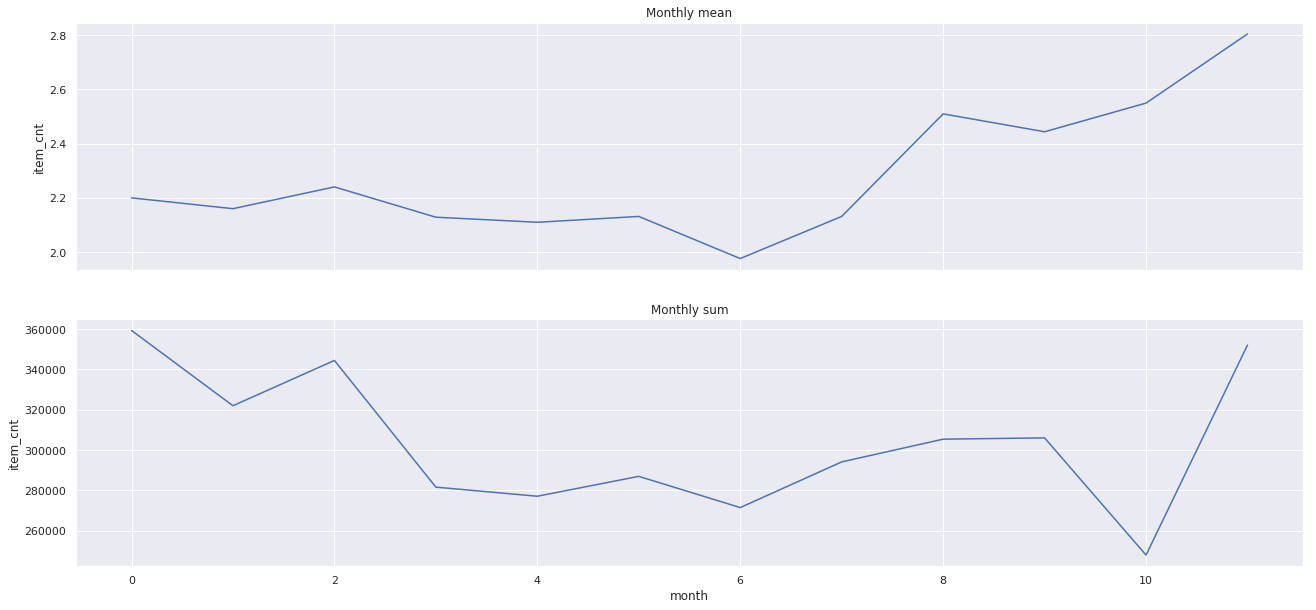

In [13]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

### What category sells more?

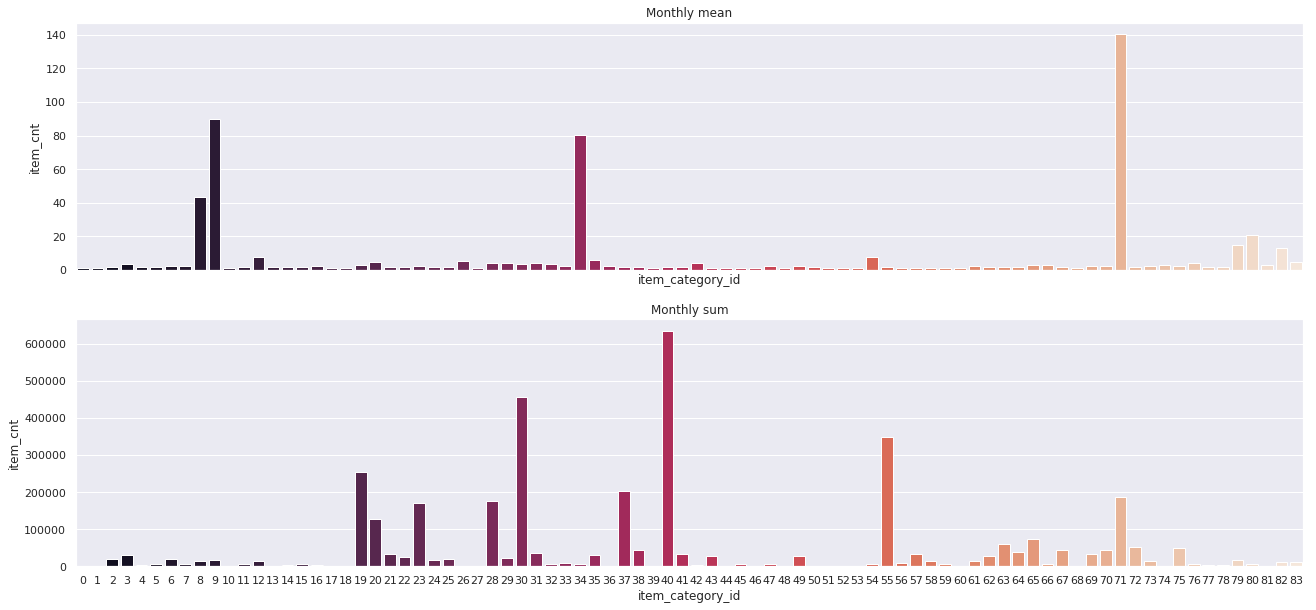

In [14]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

### What shop sells more?

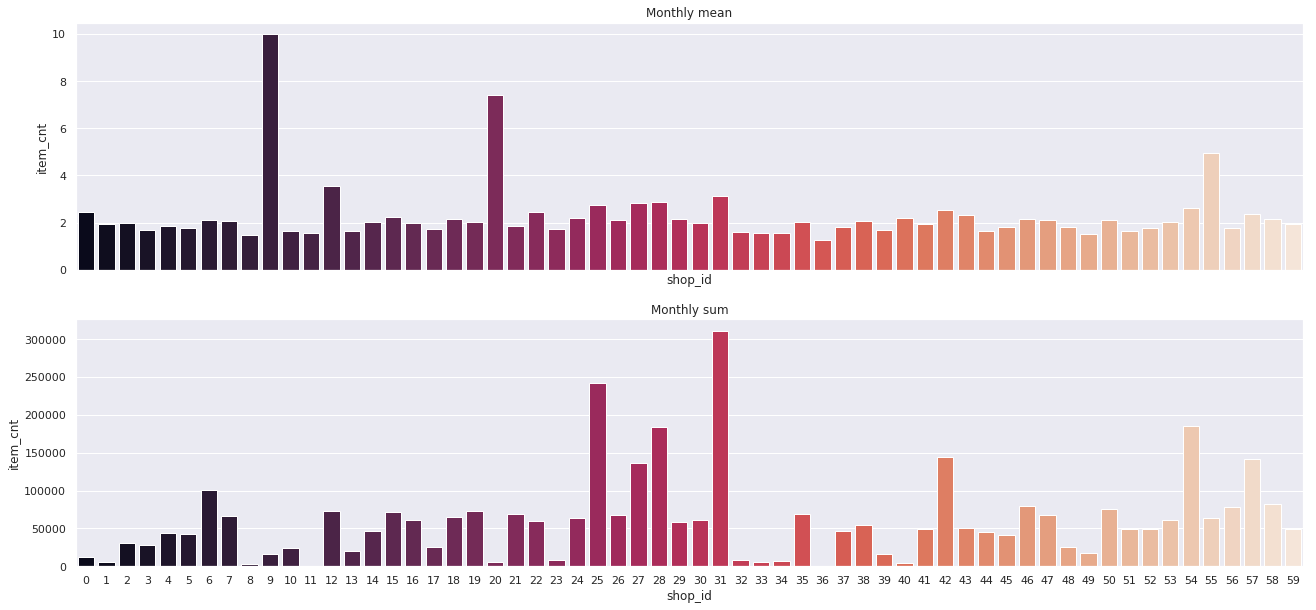

In [15]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

### Checking for outliers

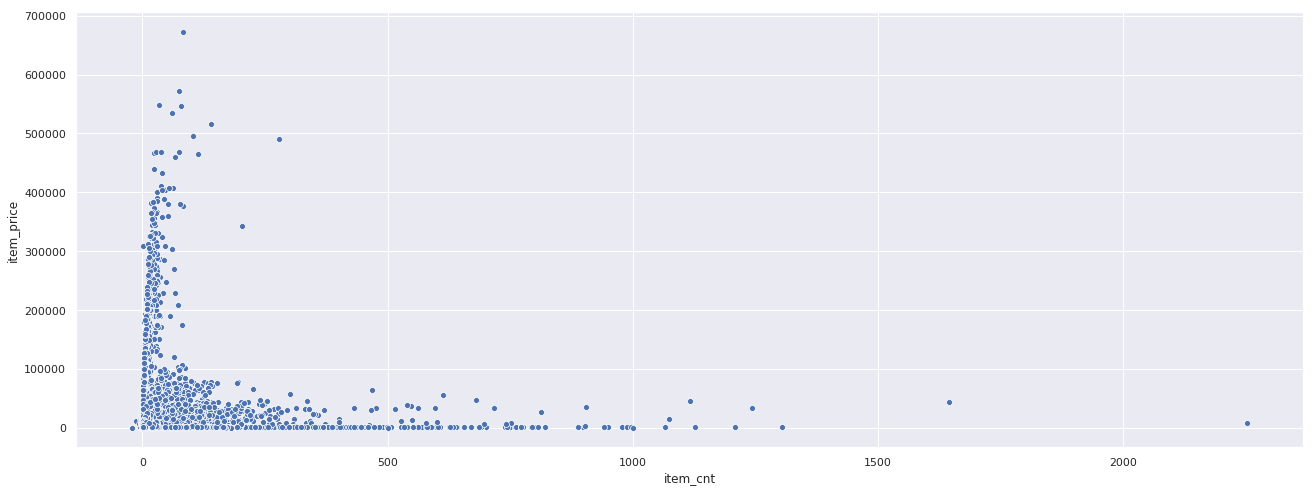

In [16]:
plt.subplots(figsize=(22, 8))
sns.scatterplot(x="item_cnt", y="item_price", data=train_monthly, palette="rocket")
plt.show()

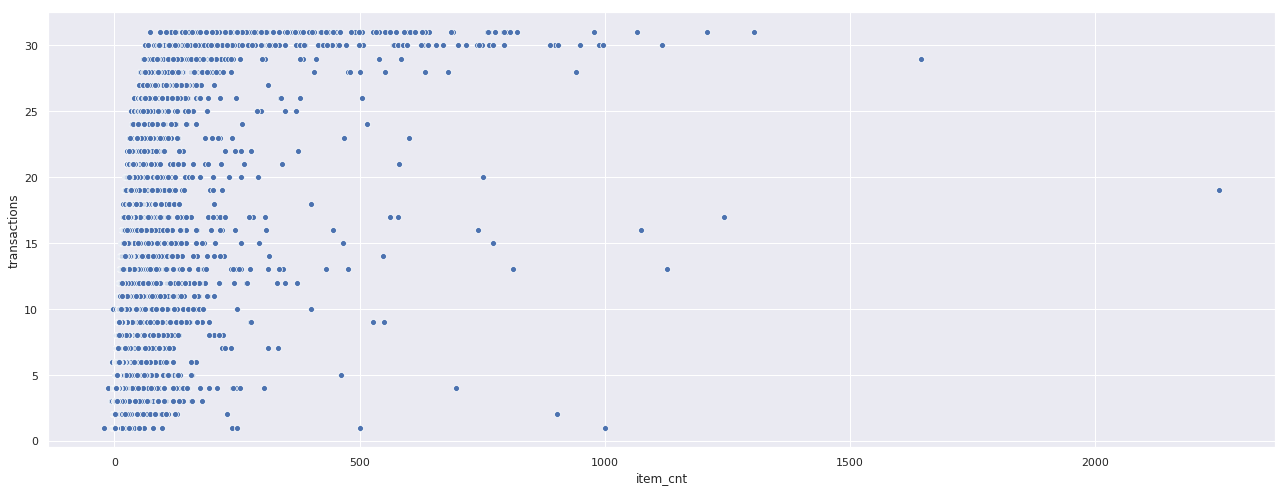

In [17]:
plt.subplots(figsize=(22, 8))
sns.scatterplot(x="item_cnt", y="transactions", data=train_monthly, palette="rocket")
plt.show()

#### Removing outliers
I'll treat "item_cnt" >= 1000, "item_price" >= 500000 and "transactions" >= 35 as outliers, so I'll remove them.

In [18]:
train_monthly = train_monthly.query('item_cnt < 1000 and item_price < 500000 and transactions < 35')

### Feature engineering

In [19]:
# Get the unitary item prices
train_monthly['item_price_unit'] = train_monthly['item_price'] // train_monthly['item_cnt']

In [20]:
# Group based features.
gp_item_price = train_monthly.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':{'min_item_price':np.min, 'max_item_price':np.max}})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

train_monthly = pd.merge(train_monthly, gp_item_price, on='item_id', how='left')

/opt/conda/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [21]:
# How much each item's price changed from its (low/high) historical price.
train_monthly['price_increase'] = train_monthly['item_price'] - train_monthly['hist_min_item_price']
train_monthly['price_decrease'] = train_monthly['hist_max_item_price'] - train_monthly['item_price']

In [22]:
# Rolling window based features [window = 12 months].
# Min values
f_min = lambda x: x.rolling(window=12, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=12, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=12, min_periods=1).mean()
# Median value
f_median = lambda x: x.rolling(window=12, min_periods=1).median()
# Stardad deviation value
f_std = lambda x: x.rolling(window=12, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_median, f_std]
function_name = ['min', 'max', 'mean', 'median', 'std']

for i in range(len(function_list)):
    train_monthly[('item_cnt_%s' % function_name[i])] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])

# Fill the empty std features with 0
train_monthly['item_cnt_std'].fillna(0, inplace=True)

In [23]:
# Lag based features.
lag_list = [1, 2, 6, 12]

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    # Fill the empty shifted features with -1
    train_monthly[ft_name].fillna(-1, inplace=True)

### Dataset after feature engineering

In [24]:
train_monthly.head(10).T

,0,1,2,3,4,5,6,7,8,9
date_block_num,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
shop_id,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
item_category_id,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00
item_id,5572.00,5573.00,5575.00,5576.00,5609.00,5612.00,5623.00,5627.00,5629.00,5630.00
item_price,7932.00,560.00,2418.00,11155.00,2381.00,3623.00,294.00,4120.00,15400.00,2060.00
item_cnt,10.00,1.00,4.00,5.00,1.00,1.00,1.00,2.00,9.00,1.00
transactions,6.00,1.00,3.00,5.00,1.00,1.00,1.00,2.00,8.00,1.00
item_cnt_month,11.00,1.00,nan,2.00,1.00,nan,3.00,4.00,5.00,1.00
year,2013.00,2013.00,2013.00,2013.00,2013.00,2013.00,2013.00,2013.00,2013.00,2013.00
month,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Data leakages

About data leakages the only thing that I'll be doing here is to use only the "shop_id" and "item_id" that appear on the test set.

In [25]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
lk_train = train_monthly[train_monthly['shop_id'].isin(test_shop_ids)]
lk_train = lk_train[lk_train['item_id'].isin(test_item_ids)]

In [26]:
print('Data set size before leaking:', train_monthly.shape[0])
print('Data set size after leaking:', lk_train.shape[0])

Data set size before leaking: 1609107
Data set size after leaking: 600153


### Train/validation split
* As we know the test set in on the future, so we should try to simulate the same distribution on our train/validation split.
* Our train set will be the first 30 blocks and the validation will be last 6 blocks.

In [27]:
train_set = lk_train.query('date_block_num < 30').copy()
validation_set = lk_train.query('date_block_num >= 30 and date_block_num < 33').copy()
test_set = lk_train.query('date_block_num == 33').copy()

train_set.dropna(subset=['item_cnt_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_month'], inplace=True)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

print('Train set records:', train_set.shape[0])
print('Validation set records:', validation_set.shape[0])
print('Test set records:', test_set.shape[0])

Train set records: 441877
Validation set records: 46181
Test set records: 28679


In [28]:
print('Train set records: %s (%.f%% of data)' % (train_set.shape[0], ((train_set.shape[0]/lk_train.shape[0])*100)))
print('Validation set records: %s (%.f%% of data)' % (validation_set.shape[0], ((validation_set.shape[0]/lk_train.shape[0])*100)))

Train set records: 441877 (74% of data)
Validation set records: 46181 (8% of data)


In [29]:
# Train and validation sets/labels. 
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_month'].astype(int)
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt_month'].astype(int)

In [30]:
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

### Build test set

In [31]:
X_test = pd.merge(test, train_monthly.drop_duplicates(subset=['shop_id', 'item_id'], keep='last'), on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test['date_block_num'] = 33
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test.fillna(X_test.mean(), inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]

In [32]:
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

### Modeling the data
* Data normalization  won't be done here since I'm using a tree based model.

### Catboost

In [33]:
cat_features = [0, 1, 5, 6]

catboost_model = CatBoostRegressor(
    iterations=400,
    verbose=50,
    random_seed=0,
    od_type='Iter',
    od_wait=15,
    task_type="GPU",
    l2_leaf_reg=10,
    depth=7
)

catboost_model.fit(
    X_train, Y_train,
    cat_features=cat_features,
    eval_set=(X_validation, Y_validation)
)

0:	learn: 11.4377923	test: 13.1315149	best: 13.1315149 (0)	total: 96ms	remaining: 38.3s
1:	learn: 11.2332551	test: 12.9782216	best: 12.9782216 (1)	total: 191ms	remaining: 37.9s
2:	learn: 11.0346264	test: 12.9136862	best: 12.9136862 (2)	total: 286ms	remaining: 37.9s
3:	learn: 10.8519591	test: 12.8277073	best: 12.8277073 (3)	total: 374ms	remaining: 37s
4:	learn: 10.6656063	test: 12.6961759	best: 12.6961759 (4)	total: 481ms	remaining: 38s
5:	learn: 10.4734714	test: 12.5676468	best: 12.5676468 (5)	total: 561ms	remaining: 36.8s
6:	learn: 10.3165744	test: 12.4869343	best: 12.4869343 (6)	total: 656ms	remaining: 36.8s
7:	learn: 10.1283605	test: 12.4126148	best: 12.4126148 (7)	total: 746ms	remaining: 36.6s
8:	learn: 9.9529255	test: 12.3009304	best: 12.3009304 (8)	total: 832ms	remaining: 36.1s
9:	learn: 9.7903889	test: 12.2174212	best: 12.2174212 (9)	total: 918ms	remaining: 35.8s
10:	learn: 9.6410473	test: 12.1329941	best: 12.1329941 (10)	total: 995ms	remaining: 35.2s
11:	learn: 9.5056813	test: 

93:	learn: 5.0991917	test: 10.0874401	best: 10.0874401 (93)	total: 7.95s	remaining: 25.9s
94:	learn: 5.0848347	test: 10.0854886	best: 10.0854886 (94)	total: 8.03s	remaining: 25.8s
95:	learn: 5.0692766	test: 10.0808655	best: 10.0808655 (95)	total: 8.11s	remaining: 25.7s
96:	learn: 5.0589330	test: 10.0801722	best: 10.0801722 (96)	total: 8.19s	remaining: 25.6s
97:	learn: 5.0444133	test: 10.0729045	best: 10.0729045 (97)	total: 8.27s	remaining: 25.5s
98:	learn: 5.0319966	test: 10.0700863	best: 10.0700863 (98)	total: 8.34s	remaining: 25.4s
99:	learn: 5.0229517	test: 10.0691778	best: 10.0691778 (99)	total: 8.41s	remaining: 25.2s
100:	learn: 5.0151279	test: 10.0687192	best: 10.0687192 (100)	total: 8.54s	remaining: 25.3s
101:	learn: 5.0012601	test: 10.0684073	best: 10.0684073 (101)	total: 8.63s	remaining: 25.2s
102:	learn: 4.9898312	test: 10.0601620	best: 10.0601620 (102)	total: 8.71s	remaining: 25.1s
103:	learn: 4.9746395	test: 10.0505565	best: 10.0505565 (103)	total: 8.8s	remaining: 25s
104:	

185:	learn: 4.4499186	test: 9.8542435	best: 9.8542435 (185)	total: 15.7s	remaining: 18s
186:	learn: 4.4468152	test: 9.8522667	best: 9.8522667 (186)	total: 15.7s	remaining: 17.9s
187:	learn: 4.4439936	test: 9.8521821	best: 9.8521821 (187)	total: 15.8s	remaining: 17.8s
188:	learn: 4.4407983	test: 9.8520414	best: 9.8520414 (188)	total: 15.9s	remaining: 17.7s
189:	learn: 4.4386946	test: 9.8520057	best: 9.8520057 (189)	total: 16s	remaining: 17.6s
190:	learn: 4.4362262	test: 9.8519997	best: 9.8519997 (190)	total: 16.1s	remaining: 17.6s
191:	learn: 4.4323475	test: 9.8503879	best: 9.8503879 (191)	total: 16.1s	remaining: 17.5s
192:	learn: 4.4293389	test: 9.8501917	best: 9.8501917 (192)	total: 16.2s	remaining: 17.4s
193:	learn: 4.4260586	test: 9.8511985	best: 9.8501917 (192)	total: 16.3s	remaining: 17.3s
194:	learn: 4.4243556	test: 9.8512782	best: 9.8501917 (192)	total: 16.4s	remaining: 17.2s
195:	learn: 4.4176918	test: 9.8400016	best: 9.8400016 (195)	total: 16.5s	remaining: 17.1s
196:	learn: 4.

277:	learn: 4.1685373	test: 9.7732566	best: 9.7732566 (277)	total: 23.5s	remaining: 10.3s
278:	learn: 4.1646102	test: 9.7723254	best: 9.7723254 (278)	total: 23.6s	remaining: 10.2s
279:	learn: 4.1619696	test: 9.7731053	best: 9.7723254 (278)	total: 23.7s	remaining: 10.1s
280:	learn: 4.1586366	test: 9.7676006	best: 9.7676006 (280)	total: 23.7s	remaining: 10.1s
281:	learn: 4.1544086	test: 9.7670447	best: 9.7670447 (281)	total: 23.8s	remaining: 9.97s
282:	learn: 4.1525586	test: 9.7657532	best: 9.7657532 (282)	total: 23.9s	remaining: 9.89s
283:	learn: 4.1515673	test: 9.7654139	best: 9.7654139 (283)	total: 24s	remaining: 9.81s
284:	learn: 4.1500534	test: 9.7652277	best: 9.7652277 (284)	total: 24.1s	remaining: 9.72s
285:	learn: 4.1493454	test: 9.7652449	best: 9.7652277 (284)	total: 24.2s	remaining: 9.64s
286:	learn: 4.1480089	test: 9.7653713	best: 9.7652277 (284)	total: 24.3s	remaining: 9.55s
287:	learn: 4.1417072	test: 9.7674554	best: 9.7652277 (284)	total: 24.4s	remaining: 9.47s
288:	learn: 

370:	learn: 3.9773318	test: 9.7080061	best: 9.7080055 (368)	total: 31.6s	remaining: 2.47s
371:	learn: 3.9765328	test: 9.7080055	best: 9.7080055 (368)	total: 31.7s	remaining: 2.39s
372:	learn: 3.9746098	test: 9.7080992	best: 9.7080055 (368)	total: 31.8s	remaining: 2.3s
373:	learn: 3.9729020	test: 9.7081154	best: 9.7080055 (368)	total: 31.9s	remaining: 2.22s
374:	learn: 3.9715177	test: 9.7085336	best: 9.7080055 (368)	total: 32s	remaining: 2.13s
375:	learn: 3.9698118	test: 9.7086780	best: 9.7080055 (368)	total: 32.1s	remaining: 2.05s
376:	learn: 3.9669853	test: 9.7062003	best: 9.7062003 (376)	total: 32.2s	remaining: 1.96s
377:	learn: 3.9661055	test: 9.7061864	best: 9.7061864 (377)	total: 32.3s	remaining: 1.88s
378:	learn: 3.9644719	test: 9.7067848	best: 9.7061864 (377)	total: 32.3s	remaining: 1.79s
379:	learn: 3.9627646	test: 9.7067608	best: 9.7061864 (377)	total: 32.4s	remaining: 1.71s
380:	learn: 3.9618728	test: 9.7068160	best: 9.7061864 (377)	total: 32.5s	remaining: 1.62s
381:	learn: 3

In [34]:
print('Model is fitted: ' + str(catboost_model.is_fitted()))
print('Model params:', catboost_model.get_params())

Model is fitted: True
Model params: {'task_type': 'GPU', 'verbose': 50, 'random_seed': 0, 'od_type': 'Iter', 'od_wait': 15, 'loss_function': 'RMSE', 'l2_leaf_reg': 10, 'depth': 7, 'iterations': 400}


In [35]:
catboost_val_pred = catboost_model.predict(X_validation)
catboost_test_pred = catboost_model.predict(X_test)

### Random forest

In [36]:
rf_model = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0, n_jobs=-1)
rf_model.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [37]:
rf_train_pred = rf_model.predict(X_train)
rf_val_pred = rf_model.predict(X_validation)
rf_test_pred = rf_model.predict(X_test)

print('Train rmse:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, rf_val_pred)))

Train rmse: 4.2798034695101945
Validation rmse: 10.222791169839088


### KNN Regressor

In [38]:
# Use only part of feature on KNN.
knn_train = X_train[['shop_id', 'item_id', 'item_cnt', 'year',
                     'month', 'item_cnt_shifted1', 'item_cnt_shifted2']]
knn_val = X_validation[['shop_id', 'item_id', 'item_cnt', 'year',
                     'month', 'item_cnt_shifted1', 'item_cnt_shifted2']]
knn_test = X_test[['shop_id', 'item_id', 'item_cnt', 'year',
                     'month', 'item_cnt_shifted1', 'item_cnt_shifted2']]

In [39]:
knn_model = KNeighborsRegressor(n_neighbors=5, leaf_size=30, n_jobs=-1)
knn_model.fit(knn_train, Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
          weights='uniform')

In [40]:
knn_train_pred = knn_model.predict(knn_train)
knn_val_pred = knn_model.predict(knn_val)
knn_test_pred = knn_model.predict(knn_test)

print('Train rmse:', np.sqrt(mean_squared_error(Y_train, knn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, knn_val_pred)))

Train rmse: 4.64142844770385
Validation rmse: 9.422329729157017


### Create new datasets with the predictions from first level models

In [47]:
# Dataset that will be the train set of the ensemble model.
first_level = pd.DataFrame(catboost_val_pred, columns=['catboost'])
first_level['random_forest'] = rf_val_pred
first_level['knn'] = knn_val_pred
first_level.head()

,catboost,random_forest,knn
0,1.68,1.45,1.40
1,2.13,1.74,1.80
2,1.32,1.40,1.20
3,1.84,1.45,1.40
4,1.60,1.74,1.40


In [48]:
# Dataset that will be the test set of the ensemble model.
first_level_test = pd.DataFrame(catboost_test_pred, columns=['catboost'])
first_level_test['random_forest'] = rf_test_pred
first_level_test['knn'] = knn_test_pred
first_level_test.head()

,catboost,random_forest,knn
0,1.82,1.45,1.40
1,1.48,1.51,3.80
2,1.43,1.74,2.00
3,1.38,1.45,2.00
4,1.48,1.51,1.00


### Ensembling

To combine the other models (1st level) predictions, I'll use a simple linear regression.

#### Stacking architecture:
* 1st level:
    * Catboost
    * Random forest
    * KNN
* 2nd level;
    * Linear Regression

In [43]:
meta_model = LinearRegression()
meta_model.fit(first_level, Y_validation)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [44]:
ensemble_pred = meta_model.predict(first_level)

print('Train rmse:', np.sqrt(mean_squared_error(Y_validation, ensemble_pred)))

Train rmse: 9.108143029176885


In [45]:
final_predictions = meta_model.predict(first_level_test)

In [49]:
prediction_df = pd.DataFrame(final_predictions.clip(0., 30.), columns=['item_cnt_month'])
prediction_df.to_csv('submission.csv')
prediction_df.head(10)

,item_cnt_month
0,1.64
1,4.64
2,1.67
3,2.06
4,0.62
5,1.89
6,3.57
7,1.30
8,2.60
9,0.91
